In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import plots

2022-12-10 02:05:24.712251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 02:05:24.921055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 02:05:24.921079: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-10 02:05:25.674677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
data_folder = 'data/'
data_file = '10101.csv'

useRaw = False
test_size = 0.2
seed = 13
window_size = 50
days = [0]
cat_matrix = True # True for neural net, any for random forest

In [3]:
df = features.load_features(data_folder + data_file)
df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.MEAN, features=["EEGv", "EMGv"])
df = df.dropna()
df = features.add_times(df)

df = features.filter_days(df, days)

skeep, _ = features.states(useRaw)
print(df[skeep].value_counts())
df.head(1)

w    11631
n     9104
r      816
Name: state, dtype: int64


,rawState,state,EEGv,EMGv,temp,EEGv_mean,EMGv_mean,time,day
49,w,w,2.976543e-09,7.784953e-10,0.0,3.147769e-09,2.602624e-09,49,0


In [4]:
x_train, x_test, y_train, y_test, le = features.split_data(df, useRaw, test_size, seed, cat_matrix)

# Neural Network

In [58]:
def baseline_model(input_dim, num_classes, lr=0.001):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                80        
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 8)                 72        
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 dense_20 (Dense)            (None, 6)                 54        
                                                                 
Total params: 414
Trainable params: 414
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

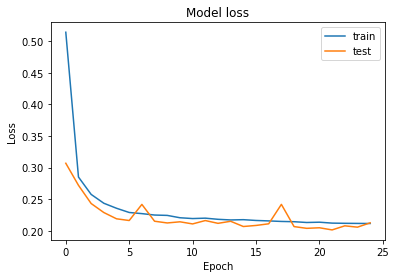

In [59]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_loss(history.history)

135/135 [==============================] - 0s 1ms/step
[[ 169    0    0    1    0    5]
 [   0    5    0   33    0    0]
 [   0    0    0    1    1    0]
 [   1    0    0 1683   51   38]
 [   0    0    0   39   96   17]
 [  13    0    0   67   51 2048]]


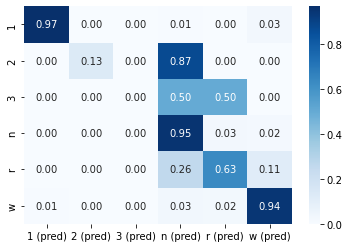

In [61]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[1729   13   55]
 [  94   45   31]
 [ 103   12 2229]]
              precision    recall  f1-score   support

           n       0.90      0.96      0.93      1797
           r       0.64      0.26      0.37       170
           w       0.96      0.95      0.96      2344

    accuracy                           0.93      4311
   macro avg       0.83      0.73      0.75      4311
weighted avg       0.92      0.93      0.92      4311



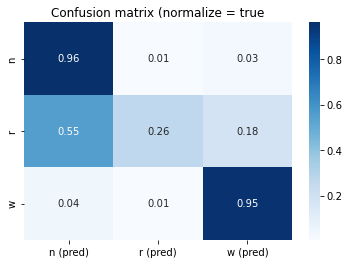

In [6]:
clf = RandomForestClassifier(random_state=seed)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

plots.plot_confusion(model=clf, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')